In [ ]:
#CODIGO REALIZADO POR LUIS NOLASCO RAMIREZ

In [2]:
#Introducir ciudad usada en el programa anterior, por defecto Alicante, en caso de no introducir la misma ciudad
#que en el programa anterior los datos y resultados no seran validos
city_name = 'Alicante'

In [4]:
#Adquisicion de los datos de las 24 horas pasadas y su correspondiente comparacion y valoracion con los
#datos de las proximas 24 horas
import datetime
import json
import urllib.request
import csv

#Construye la url de la llamada a la API para la obtencion de la informacion de las 24 horas pasadas
def url_builder1(lat,lon):
    #Calcula el timestamp de 24 horas atras en el tiempo en UNIX TIME
    now=datetime.datetime.now()
    timestampnow = round(datetime.datetime.timestamp(now))
    timestamp24h = str(timestampnow-86400)
    #Construye la url con unidades del sistema metrico
    user_api = 'a7d98c4cd30be66e3c00580621203170'
    unit = 'metric'  # For Fahrenheit use imperial, for Celsius use metric, and the default is Kelvin.
    api = 'https://api.openweathermap.org/data/2.5/onecall/timemachine?lat='
    full_api_url = api + str(lat) + '&lon=' + str(lon) + '&dt=' + timestamp24h + '&appid=' + user_api + '&units=' + unit
    print(full_api_url)
    return full_api_url

#Devuelve los datos de la url en formato json
def data_fetch(full_api_url):
    url = urllib.request.urlopen(full_api_url)
    output = url.read().decode('utf-8')
    raw_api_dict = json.loads(output)
    url.close()
    #print(raw_api_dict)
    return raw_api_dict

if __name__ == '__main__':
    try:
        #Obtencion de las coordenadas de la ciudad deseada
        #Se usa la API call a current weather con el nombre de la ciudad deseado, uno de los campos que proporciona
        #son sus coordenadas
        url_for_coord = 'https://api.openweathermap.org/data/2.5/weather?q=' + city_name + '&appid=a7d98c4cd30be66e3c00580621203170&units=metric'
        datos_coord = data_fetch(url_for_coord)
        lat = datos_coord['coord']['lat']
        lon = datos_coord['coord']['lon']
        
        #Adquisicion de los datos de las 24 horas pasadas
        datos=data_fetch(url_builder1(lat,lon))
        #print(datos)
        
        #Incrementos en las distintas variables, es la media de los incrementos que se producen de un dia con 
        #respecto al otro, siendo el incremento = dato(hora_prevision)-dato(hora_prevision-24)
        temp_mean = 0
        clouds_mean = 0
        humidity_mean = 0
        windspeed_mean = 0
        
        #Media de las distintas variables para las proximas 24 horas
        forecast_temp_mean = 0
        forecast_clouds_mean = 0
        forecast_windspeed_mean = 0
        
        #Horas de sol en las proximas 24 horas, calculadas como aquellas horas entre la salida y la puesta de
        #sol que tengan menos de un 25% de nubes
        forecast_sun_hours = 0
        sunrise = int(datetime.datetime.fromtimestamp(datos['current']['sunrise']).strftime("%H")) #hora de salida del sol
        sunset = int(datetime.datetime.fromtimestamp(datos['current']['sunset']).strftime("%H")) #hora de la puesta de sol
        forecast=[]
        with open('forecast24h.csv') as File:
            reader = csv.reader(File,delimiter=',', quotechar=',', quoting=csv.QUOTE_MINIMAL)
            first_line=True
            i=0
            #Matriz que almacena cada incremento por horas de forma individual
            matrix=[]
            #Recorre todo el archivo csv fila a fila
            for row in reader:
                if first_line: #De la primera fila solo guarda los nombres de los distintos campos
                    matrix.append(row)
                    forecast.append(row)
                    first_line=False
                else:
                    #Calculo de los incrementos de cada variable para la fila actual, dato(hora_prevision)-dato(hora_prevision-24)
                    line = [round(float(row[0])),round(float(row[1])-datos['hourly'][i]['temp'],2),round(float(row[2])-datos['hourly'][i]['feels_like'],2),round(float(row[3])-datos['hourly'][i]['humidity'],2),round(float(row[4])-datos['hourly'][i]['clouds'],2),round(float(row[5])-datos['hourly'][i]['wind_speed'],2),round(float(row[6])-datos['hourly'][i]['wind_deg'],2)]
                    matrix.append(line)
                    forecast.append(row)
                    #Suma de los valores para el calculo de las medias de los incrementos
                    temp_mean = temp_mean + round(float(row[1])-datos['hourly'][i]['temp'],2)
                    clouds_mean = clouds_mean + round(float(row[4])-datos['hourly'][i]['clouds'],2)
                    humidity_mean = humidity_mean + round(float(row[3])-datos['hourly'][i]['humidity'],2)
                    windspeed_mean = windspeed_mean + round(float(row[5])-datos['hourly'][i]['wind_speed'],2)
                    
                    #Suma de los valores para el calculo de las medias de la prevision
                    forecast_temp_mean = forecast_temp_mean + float(row[1])
                    forecast_clouds_mean = forecast_clouds_mean + float(row[4])
                    forecast_windspeed_mean = forecast_windspeed_mean + float(row[5])
                    
                    #Calculo de las horas de luz
                    timestamp = round(float(row[0]))
                    now = datetime.datetime.fromtimestamp(timestamp)
                    hour = int(now.strftime("%H"))
                    if float(row[4]) < 30 and hour >= sunrise and hour <= sunset:
                        forecast_sun_hours = forecast_sun_hours + 1
                    #print(line)
                    i=i+1
            
            #Calculo de las medias de los incrementos, suma_total/total_elementos
            temp_mean = temp_mean/i
            clouds_mean = clouds_mean/i
            humidity_mean = humidity_mean/i
            windspeed_mean = windspeed_mean/i
            
            #Calculo de las medias de la prevision, suma_total/total_elementos
            forecast_temp_mean = forecast_temp_mean/i
            forecast_clouds_mean = forecast_clouds_mean/i
            forecast_windspeed_mean = forecast_windspeed_mean/i

            
            #Comparacion de los incrementos en las principales variables
            if temp_mean > 0:
                print("La temperatura de las proximas 24 horas sera",round(temp_mean,2),"grados superior con respecto a las ultimas 24 horas")
            else:
                print("La temperatura de las proximas 24 horas sera",abs(round(temp_mean,2)),"grados inferior con respecto a las ultimas 24 horas")
            if clouds_mean > 0:
                print("El cielo se encontrara un", round(clouds_mean,2),"% mas nublado")
            else:
                print("El cielo se encontrara un", abs(round(clouds_mean,2)),"% mas despejado")
            if windspeed_mean > 0:
                print("Y tendremos vientos", round(windspeed_mean,2),"veces mas fuertes")
            else:
                print("Y tendremos vientos", abs(round(windspeed_mean,2)),"veces mas suaves")
                
            #Valoracion de la prediccion obtenida    
            if forecast_temp_mean > 25:
                print("Las proximas 24 horas seran bastante calurosas con",round(forecast_temp_mean,2),"grados")
            elif forecast_temp_mean > 15:
                print("Las proximas 24 horas seran templadas con",round(forecast_temp_mean,2),"grados")
            else:
                print("Las proximas 24 horas seran frias con",round(forecast_temp_mean,2),"grados")
            print("Acompañado de un",round(forecast_clouds_mean,2),"% de nubes")
            if forecast_windspeed_mean > 20:
                print("Las proximas 24 horas contaran con vientos muy fuertes de",round(forecast_windspeed_mean,2),"metros por segundo")
            elif forecast_windspeed_mean > 11:
                print("Las proximas 24 horas contaran con vientos fuertes de",round(forecast_windspeed_mean,2),"metros por segundo")
            elif forecast_windspeed_mean > 6:
                print("Las proximas 24 horas contaran con vientos moderados de",round(forecast_windspeed_mean,2),"metros por segundo")
            else:
                print("Las proximas 24 horas contaran con vientos muy suaves de",round(forecast_windspeed_mean,2),"metros por segundo")
            
            
            #Valoracion de la prevision para la produccion de energias renovables
            print()
            if forecast_windspeed_mean > 22:
                print("Los vientos de las proximas horas son de",round(forecast_windspeed_mean,2),"m/s superando el limite de seguridad de los generadores eolicos, haciendo imposible su uso continuado")
            elif forecast_windspeed_mean > 10:
                print("Los vientos de las proximas horas son de", round(forecast_windspeed_mean,2),"m/s obteniendo el maximo potencial de los generadores eolicos")
            elif forecast_windspeed_mean > 4:
                print("Los vientos de las proximas horas son de", round(forecast_windspeed_mean,2),"m/s permitiendo asi el correcto funcionamiento de los generadores eolicos")
            else:
                print("Los vientos de las proximas horas son de", round(forecast_windspeed_mean,2),"m/s siendo insuficientes para el correcto funcionamiento de los generadores eolicos")
            if forecast_sun_hours < 5:
                print("En las proximas 24 horas solo tendremos",forecast_sun_hours,"horas de luz, siendo un dia poco propicio para la generacion de la energia solar")
            else:
                print("En las proximas 24 horas tendremos",forecast_sun_hours,"horas de luz, siendo un buen dia para la generacion de energia solar")
            
    except IOError:
        print('error')

https://api.openweathermap.org/data/2.5/onecall/timemachine?lat=38.3452&lon=-0.4815&dt=1617116006&appid=a7d98c4cd30be66e3c00580621203170&units=metric
La temperatura de las proximas 24 horas sera 0.94 grados superior con respecto a las ultimas 24 horas
El cielo se encontrara un 55.17 % mas nublado
Y tendremos vientos 0.61 veces mas suaves
Las proximas 24 horas seran templadas con 17.25 grados
Acompañado de un 55.17 % de nubes
Las proximas 24 horas contaran con vientos moderados de 6.16 metros por segundo

Los vientos de las proximas horas son de 6.16 m/s permitiendo asi el correcto funcionamiento de los generadores eolicos
En las proximas 24 horas tendremos 5 horas de luz, siendo un buen dia para la generacion de energia solar


En azul la predición y en naranja las ultimas 24 horas, siendo 0 la hora actual para la prediccion y 0 hace 24 horas para el historico del tiempo


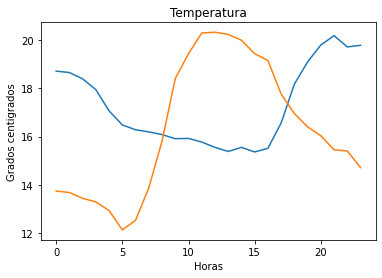

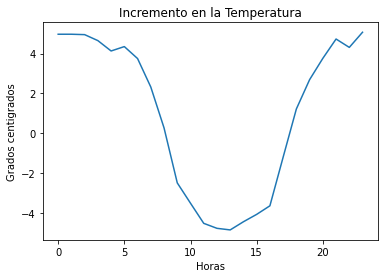

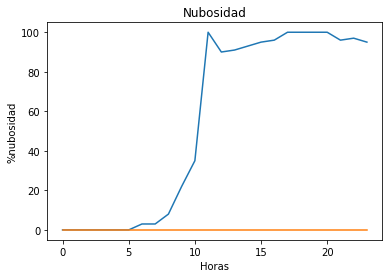

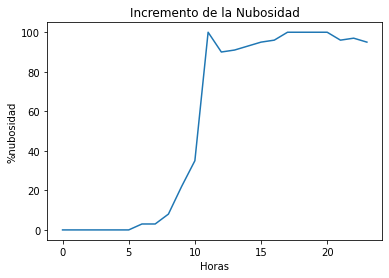

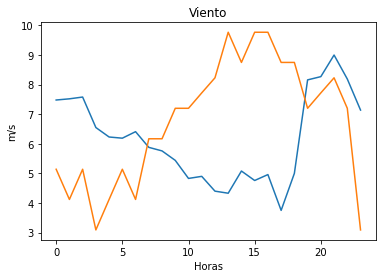

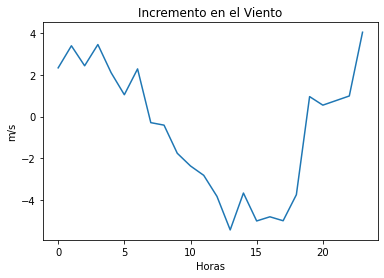

In [5]:
#Graficar las diferentes variables de forma comparativa para apreciar la diferencia entra la prediccion a futuro y
#el clima de las ultimas 24 horas así como sus respectivos incrementos por hora

import matplotlib.pyplot as plt
import datetime

#Vectores de datos para el eje "y" de las graficas
temp_past=[]
temp_future=[]
clouds_past=[]
clouds_future=[]
wind_past=[]
wind_future=[]
x=[]
delta_t=[]
delta_c=[]
delta_w=[]

#Adquisicion de todos los datos necesarios para las graficas
for i in range(24):
    x.append(i)
    temp_past.append(datos['hourly'][i]['temp'])
    temp_future.append(float(forecast[i+1][1]))
    clouds_past.append(datos['hourly'][i]['clouds'])
    clouds_future.append(float(forecast[i+1][4]))
    wind_past.append(datos['hourly'][i]['wind_speed'])
    wind_future.append(float(forecast[i+1][5]))
    delta_t.append(matrix[i+1][1])
    delta_c.append(matrix[i+1][4])
    delta_w.append(matrix[i+1][5])

#Graficas de temperatura
print("En azul la predición y en naranja las ultimas 24 horas, siendo 0 la hora actual para la prediccion y 0 hace 24 horas para el historico del tiempo")
plt.title("Temperatura")
plt.xlabel("Horas")
plt.ylabel("Grados centigrados")
plt.plot(x,temp_future)
plt.plot(x,temp_past)
plt.show()

plt.title("Incremento en la Temperatura")
plt.xlabel("Horas")
plt.ylabel("Grados centigrados")
plt.plot(x,delta_t)
plt.show()

#Graficas de nubosidad
plt.title("Nubosidad")
plt.xlabel("Horas")
plt.ylabel("%nubosidad")
plt.plot(x,clouds_future)
plt.plot(x,clouds_past)
plt.show()

plt.title("Incremento de la Nubosidad")
plt.xlabel("Horas")
plt.ylabel("%nubosidad")
plt.plot(x,delta_c)
plt.show()

#Graficas de viento
plt.title("Viento")
plt.xlabel("Horas")
plt.ylabel("m/s")
plt.plot(x,wind_future)
plt.plot(x,wind_past)
plt.show()

plt.title("Incremento en el Viento")
plt.xlabel("Horas")
plt.ylabel("m/s")
plt.plot(x,delta_w)
plt.show()
